<a href="https://colab.research.google.com/github/MatteoGioia/ViT2MLPMixerKD/blob/main/ViT2MLPKD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Team info

| Team member | Mail | Responsibilities |
|---|---|---|
|Torri Alessandro | torri.1835715@studenti.uniroma1.it | First code draft, contributed equally to the rest |
|Gioia Matteo | gioia.1995989@studenti.uniroma1.it | First report draft, contributed equally to the rest|
|Madeddu Francesco | madeddu.1838662@studenti.uniroma1.it | Testing on imnet64, contributed equally to the rest|
|Lucchesi Andrea | lucchesi.1659599@studenti.uniroma1.it  | General testing, contributed equallty to the rest |

Other responsibilities include testing, minor fixes to code, etc...

# Knowledge distillation - report
In this notebook, we will try to distillate the knowledge of a Vision Transformer into a MLP Mixer. 


## Introduction 

Knowledge distillation is a relatively recent technique developed in order to decrease the size of deep neural networks. In practice, it revolves around transferring the "knowledge" of a **big teacher model** to a much **smaller student** that has the same architecture but less parameters. The teacher model thus learns to emulate the teacher, attaining close performances while being considerably simpler/smaller.<br>
The distillation process is achieved by applying the chosen loss function over the outputs of the teacher and the outputs of the student. These can either be their **softmaxes**, in which case we refer to them as **soft labels**, or the **actual predictions**, also known as **hard labels**. Other variants of this process exist, for instance using a **weighted mix of soft/hard labels** and the actual ground truth, or **choosing the one to use randomly at each iteration**.

**[Motivation of our work]** Knowledge Distillation has been so far mostly limited to homogenous models, i.e. models that have the same architecture. This should intuitively work as the bigger model, which we'll call $T$, has the ability to explore a bigger hypotesis space $H$ than the student $S$ given the greater amount of parameters. However, not all of its expressive power it's possibly needed to find an optimal function $f_{\theta}$ w.r.t. to the loss. As such, it is possible to distillate the knowledge acquired in this "exploration" process into a much smaller model which can approximate $f_{\theta}$ but that would have explored a much smaller hypotesis space if trained on its own. <br>
This project focuses on exploring **whether it's actually possible to perform distillation between 2 different model architectures**, i.e. if it's actually possible to not only distillate the knowledge but also perform a "translation" from a model to another. Ideally, the closer the two architectures are the easier this process should be, however we intentionally choose two very different models to see if even in this case it is somehow possible to attain comparably good performances. 


## Related work

The idea behind KD was first presented back in 2015 in [Distilling the Knowledge in a Neural Network](https://arxiv.org/pdf/1503.02531.pdf). For what regards KD with Vision Transformers, a model called DeiT was presented in [Training data-efficient image transformers & distillation through attention](https://arxiv.org/pdf/2012.12877v2.pdf). To the best of our knowledge, heterogenous KD has been explored in [Heterogeneous Knowledge Distillation Using Information Flow Modeling](https://openaccess.thecvf.com/content_CVPR_2020/html/Passalis_Heterogeneous_Knowledge_Distillation_Using_Information_Flow_Modeling_CVPR_2020_paper.html). However, the models explored are different from the ones we propose. A full list of references is available at https://github.com/MatteoGioia/ViT2MLPMixerKD 

## Methodology and setup

To perform distillation, we first defined the datasets that we wanted to use.
Given the complexity of the study (heterogeneous KD) we opted for a relatively simple task: classification on **CIFAR100** and **Imagenet1k**. Eventually, we had to subsistute **Imagenet1k** for it's downscaled variant **Imagenet64**, which has the same samples of the original dataset but downscaled to $64 \times 64$ images. <br> 
After that, we decided the models that we were going to use as teacher and student. We used a (large) Vision Transformer as the teacher, as it's a model with very good performance on both CIFAR100 and Imagenet64 (around 90% accuracy)and has a great number of parameters (around 90 millions). For what regards the student, we tested the following configurations of MLP Mixers:

|Name|#Blocks|Embedding Dim|MLP ratio| #Parameters |
|---|---|---|---|---|
|Small student| 6 | 128 | (0.5, 4)| 0.863 mln|
|Medium student 1 | 6 | 256 | (0.5, 4) | 3.298 mln |
|Medium student 2 | 8 | 256 | (0.5, 4) | 4.384 mln |
|Big student | 12 | 256 | (0.5, 4) | 6.557 mln |

We conducted 4 different experiments:
- KD between a ViT and MLP mixer on CIFAR100
- KD between a ViT and MLP mixer on Imagenet64
- KD between a ViT and MLP mixer using a linear embedding of the teacher labels
- KD between a ViT and a different student (a small ResNet)

Each experiment was conducted for at least 60 epochs using AdamW as the optimizer (with default parameters) with default weight decay and a CosineAnnealing learning scheduler. <br>
For what regards knowledge distillation, we tested the following variants:
- **soft distillation**, applying a CrossEntropyLoss on the logits of the student and the teacher;
- **hard distillation**, applying a CrossEntropyLoss on the logits of the student and the hard label (predictions) of the teacher;
- **weighted distillation**, computing the loss as a combination of a CrossEntropyLoss on the logits of the student and the teacher and a CrossEntropyLoss on the logits of the student and the actual ground truths;
- **random distillation**, choosing randomly at each iteration whether to compute the loss as in a soft distillation or using the actual ground truths.

Other libraries used include Pytorch Lighting, HuggingFace, Pytorch Image Models and Weights&Biases to track the experiments.



## Experimental results (quantitative and qualitative)

**[KD on CIFAR]** The first round of experiments on CIFAR100 showed average results, with most of the models performing very well on training data and reaching upwards of 80% of accuracy but not able to go over 50% on the validation and test. Putting aside possible implementation errors, we initially thought that this was due to overfitting on the relatively small amount of data and the training plots seemed to confirm our hypotesis. In fact, as the training went by the accuracy on training data continued to improve, but the accuracy on validation did not.

<img src="https://drive.google.com/uc?id=1wnA0MLP4ycaPC_htcqZtnOwSzsr-ehjC"
     alt="label"
     height=400
     width=1000
     style="display: block; margin-right: auto; margin-left: auto; height: 2%;" />


**[KD on Imagenet64]** To verify the validity of our hypotesis, we then procedeed to test the KD process on the very same models that we believed were overfitting on CIFAR100. Ideally, the greater amount of data in Imagenet64 should have helped against overfitting. However, after extensive testing, we observed that performance on this dataset was even worse, capping around 20% of validation accuracy with the smallest student.

Note that: the models on imagenet needed a lot of time to be trained, so we restarted some runs from checkpoints and we called the new run "run_name_restart"

<img src="https://drive.google.com/uc?id=1rhNWeFW7XXhewHYiFhisMeH-hTidnuXR"
     alt="label"
     height=400
     width=1000
     style="display: block; margin-right: auto; margin-left: auto; height: 2%;" />

**[KD with linear embeddings]** With overfitting out of the picture, we investigated whether using a linear embedding of the labels would somehow help the student model in the learning process. Ideally, this small MLP network should have acted as a "translator" between the teacher and the student. This idea was motivated by the fact that altough the outputs of the 2 models might not be "compatible" due to the different architectures and might need a little extra help during training. Sadly, this did not help at all and actually tanked the performance to a mere 10% validation accuracy on CIFAR100. It would be interesting to see whether this approach could work on embedding produced at earlier stages of the teacher model.

<img src="https://drive.google.com/uc?id=1FYaPXL0CvqZ9ZI7rC-gfRJLA_RRX5-wF"
     alt="label"
     height=400
     width=1000
     style="display: block; margin-right: auto; margin-left: auto; height: 2%;" />

**[KD with a different student]** To exclude the possibility that our student was actually "unable" to learn, we decided to try for a different student. This time, we tested a Resnet18 and a Resnet101 and we saw even worse performances than the mixer, with the ResNets heavily overfitting on the training data from the first few epochs. 

<img src="https://drive.google.com/uc?id=1bFL0kUyvubR1-Lt_49mc5VR6UBaLUEUr"
     alt="label"
     height=400
     width=1000
     style="display: block; margin-right: auto; margin-left: auto; height: 2%;" />

**[KD with different strategies]** We tested different kinds of distillations, but we did not notice a significant difference. However, the weighted distillation seemed to provide a slight improvement (+2% on test set accuracy), suggesting that the distillation is somehow aiding training.

<img src="https://drive.google.com/uc?id=1crydHyvYptVjKg_2cntSfCsXQDZd2qho"
     alt="label"
     height=400
     width=1000
     style="display: block; margin-right: auto; margin-left: auto; height: 2%;" />

## Conclusions and future work

Heterogenous Knowledge Distillation proved to be not an easy task given the intristic complexity of transferring knowledge between 2 different models. However, we don't feel like saying it cannot work at all, but rather that more time and resources must be invested to come to a definitive conclusion. Thus, we provide some insights on what could be the direction of future works regarding this topic.

For what regards future work, one possible idea would be to **test more extensively on bigger datasets**, namely on the full size Imagenet. As of now, testing on Imagenet64 is still hardly viable because it requires a lot of time (at least on our hardware). It would also be interesting to investigate the performance of a **teacher/student combination in which the architecture is more simila**r, e.g. 2 convolutional networks. Finally, it **could be worth  testing whether using embeddings at earlier layers** of the teacher network could produce a better performance when used to train the student.

# Knowledge distillation - code

##0. Setup

### 0.1 Downloads and imports

In [1]:
#@title Downloads
!pip install -q transformers datasets[vision] pytorch-lightning
!pip install -q wandb
!pip install -q einops
!pip install -q timm

     |████████████████████████████████| 5.8 MB 38.9 MB/s 
     |████████████████████████████████| 452 kB 68.9 MB/s 
     |████████████████████████████████| 800 kB 69.6 MB/s 
     |████████████████████████████████| 7.6 MB 67.6 MB/s 
     |████████████████████████████████| 182 kB 73.6 MB/s 
     |████████████████████████████████| 125 kB 79.0 MB/s 
     |████████████████████████████████| 512 kB 75.8 MB/s 
     |████████████████████████████████| 212 kB 80.2 MB/s 
     |████████████████████████████████| 132 kB 68.5 MB/s 
     |████████████████████████████████| 127 kB 59.6 MB/s 
     |████████████████████████████████| 1.9 MB 39.3 MB/s 
     |████████████████████████████████| 174 kB 57.3 MB/s 
     |████████████████████████████████| 182 kB 81.4 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 173 kB 82.3 MB/s 
     |████████████████████████████████| 168 kB 80.5 MB/s 
     |████████████████████████████████| 168 kB 85.2 MB/s 
     |██████████

In [2]:
#@title Imports

# general imports
from google.colab import drive
from typing import *
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import wandb

# pytorch imports
import torchvision
import pytorch_lightning as pl
from pytorch_lightning import callbacks
import transformers
import torch

import numpy as np
import einops
import torch.nn as nn
import torch.nn.functional as F

#mlp mixer import
import timm

seed : int = 42
device : str = "cuda" if torch.cuda.is_available() else "cpu"
pl.seed_everything(seed)
print(f"You are going to train the distillation on {device}")

INFO:lightning_lite.utilities.seed:Global seed set to 42


You are going to train the distillation on cuda


In [3]:
#@title Move to the project folder (GDrive)
#This creates the folder if it does not already exist
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive

if not os.path.exists("ViT2MLP"):
  os.mkdir("ViT2MLP")

%cd ViT2MLP

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/ViT2MLP


In [ ]:
#@title Download imagenet64
#Warning: the total size (zip + untarred file) is 20 gb!

#!wget https://pjreddie.com/media/files/imagenet64.tar 
#!tar -xvf imagenet64.tar
#!rm -rf imagenet64.tar

def get_imagenet64_data():
  # Data augmentation transformations. Not for Testing!
  transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(64), # Takes images smaller than 64 and enlarges them
    torchvision.transforms.RandomCrop(64, padding=4, padding_mode='edge'), # Take 64x64 crops from 72x72 padded images
    torchvision.transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
    torchvision.transforms.ToTensor(),
  ])

  transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
  ])

  trainset = torchvision.datasets.ImageFolder(root='./imagenet64/train/', transform=transform_train)
  testset = torchvision.datasets.ImageFolder(root='./imagenet64/val/', transform=transform_test)

  return trainset, testset

imnet64_train, imnet64_test = get_imagenet64_data()

In [4]:
#@title Download cifar100
cifar100_train = torchvision.datasets.CIFAR100(root = ".",
                                               train = True,
                                               download = True,
                                               transform=torchvision.transforms.functional.pil_to_tensor)
cifar100_test = torchvision.datasets.CIFAR100(root = ".",
                                               train = False,
                                               download = True,
                                               transform=torchvision.transforms.functional.pil_to_tensor)

Files already downloaded and verified
Files already downloaded and verified


###0.2 Utility functions

In [5]:
#@title Visualization function
def visualize(datapoint : int, dataset : torchvision.datasets):
    image, label = dataset[datapoint]
    plt.title(f"Ground truth: {dataset.classes[label]}")
    plt.imshow(torchvision.transforms.functional.to_pil_image(image))

In [6]:
#@title Function to output a prediction of the teacher
def predict(image : torch.Tensor,
            model : nn.Module,
            feature_extractor : Any = None) -> str:
    with torch.no_grad():
        if feature_extractor is None:
            logits = model(image)
        else:
            inputs : torch.Tensor = feature_extractor(image, return_tensors="pt").to(device)
            logits = model(**inputs).logits
      
    # model predicts one of the classes
    predicted_label : int = logits.argmax(-1).item()
   
    return predicted_label


In [7]:
#@title Count the parameters of a model
def count_params(model : nn.Module) -> int:
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    param_num = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
    return param_num

##1. Code for the models

###1.1 Pre-trained teacher (ViT)
Load ViT finetuned on Imagenet1k or CIFAR100. To load the non fine-tuned version use **"google/vit-base-patch16-224-im21k"**

References:
- [main transformer docs](https:huggingface.co/docs/transformers/index) 
- [ViT Docs](https://huggingface.co/docs/transformers/model_doc/vit)
- [lighting finetuning example](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/VisionTransformer)

In [ ]:
#@title Load the model
cifar100_vit = "Ahmed9275/Vit-Cifar100"
imagenet1k_vit = "google/vit-base-patch16-224"
tuned_on : str = "imagenet1k" #@param['cifar100', 'imagenet1k']
if tuned_on == "cifar100":
    model_str = cifar100_vit
else:
    model_str = imagenet1k_vit


feature_extractor = transformers.ViTFeatureExtractor.from_pretrained(model_str) 

teacher = transformers.ViTForImageClassification.from_pretrained(model_str).to(device)
print('Trainable Parameters: %.3fM' % count_params(teacher))

Downloading:   0%|          | 0.00/265 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/755M [00:00<?, ?B/s]

Trainable Parameters: 197.767M


0
Predicted: tench, Tinca tinca


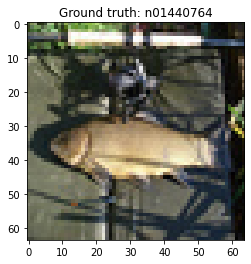

In [ ]:
#@title Qualitative comparison with ground truth {run : "auto"}
datapoint_number : int = 1 #@param{type:"integer"}

dataset = cifar100_test if tuned_on == "cifar100" else imnet64_test
try:
    visualize(datapoint_number, dataset)
    label : int = predict(dataset[datapoint_number][0], teacher, feature_extractor)
    prediction : str = teacher.config.id2label[label]
    print(f"Predicted: {prediction}")
except IndexError:
    print(f"The dataset max index is {len(dataset)-1}")


In [ ]:
#@title Quantitative result: Accuracy
'''
Warning: this cell takes 15min to be executed (on GPU).
'''

#correct = 0
#for i in tqdm(range(len(dataset))):
#    pr_label = predict(dataset[i][0], teacher, feature_extractor)
#    gt_label = dataset[i][1]
#    if pr_label == gt_label:
#        correct += 1
#accuracy = round(correct*100 / len(dataset),2)
#print(f"The accuracy of the model for the dataset {tuned_on} is: {accuracy}%")

##### TODO remove (?) ####

###1.2.0 Generic student

In [8]:
class GenericStudent(pl.LightningModule):
    def __init__(self,
                 learning_rate : float = 0.001,
                 distillating : str = None,
                 distillation_prob : float = None):
        super().__init__()
        assert(distillation_prob is None or distillating != "random")

        self.lr = learning_rate
        self.distillating = distillating
        self.distillation_prob = distillation_prob

        self.loss_fn = nn.CrossEntropyLoss()

        ## logging attributes
        self.loss = { "train" : 0, "val" : 0, "test" : 0 }
        self.accuracy = { "train" : 0, "val" : 0, "test" : 0 }
        self.tot = { "train" : 0, "val" : 0, "test" : 0 }
        self.first_test = True

        super().save_hyperparameters()
    
    def step(self, batch : torch.Tensor ,step_type : str) -> torch.Tensor:
        # get ground truth and data
        if step_type == "test":
            data, labels = batch
            gt : torch.Tensor = labels
        else:
            data, labels, teacher_labels = batch
            if self.distillating is None:
                gt : torch.Tensor = labels
            else:
                teacher_labels = torch.nn.functional.softmax(teacher_labels, dim = -1)
                if self.distillating == "soft":
                    gt : torch.Tensor = teacher_labels
                elif self.distillating == "hard":
                    gt : torch.Tensor = teacher_labels.argmax(dim = -1)
                elif self.distillating == "random":
                    r : float = random.random()
                    if r <= self.distillation_prob:
                        gt : torch.Tensor = teacher_labels
                    else:
                        gt : torch.Tensor = labels
                elif self.distillating == "weighted":
                    gt = labels
                    gt_t : torch.Tensor = teacher_labels
        
        batch_size : int = labels.shape[0]

        # compute predictions
        logits = self(data.float())
        if self.distillating == "weighted" and step_type != "test":
          loss = 0.3 * self.loss_fn(logits,gt) + 0.7 * self.loss_fn(logits,gt_t)
        else:
          loss = self.loss_fn(logits,gt)
        predictions = logits.argmax(dim = -1)

        # update logging variables
        self.loss[step_type] += loss.item()
        self.accuracy[step_type]  += (predictions == labels).sum().item()
        self.tot[step_type]  += batch_size

        return loss

    def training_step(self, batch : torch.Tensor ,batch_idx : int):
        return self.step(batch,"train")
    
    def validation_step(self,batch,batch_idx):
        return self.step(batch,"val")
    
    def test_step(self,batch,batch_idx):
        return self.step(batch,"test")
    
    def epoch_end(self, step_type : str, num_outputs : int) -> None:
        # compute loss
        avg_loss = self.loss[step_type] / num_outputs
        self.loss[step_type] = 0
        # compute accuracy
        accuracy = self.accuracy[step_type] / self.tot[step_type]
        self.accuracy[step_type] = 0
        self.tot[step_type] = 0
        # log
        self.log("epoch", float(self.current_epoch))
        if step_type != "test":
            self.log(f"{step_type}_loss",avg_loss)
            self.log(f"{step_type}_accuracy",accuracy)
        elif self.first_test:
          self.log("test_loss_before",avg_loss)
          self.log("test_accuracy_before",accuracy)
          self.first_test = False
        else:
          self.log("test_loss_after",avg_loss)
          self.log("test_accuracy_after",accuracy)
    
    def training_epoch_end(self, outputs) -> None:
        self.epoch_end("train",len(outputs))
    
    def validation_epoch_end(self, outputs) -> None:
        self.epoch_end("val",len(outputs))
    
    def test_epoch_end(self, outputs) -> None:
        self.epoch_end("test",len(outputs))

    def configure_optimizers(self) -> torch.optim:
        return torch.optim.AdamW(self.parameters(), lr = self.lr)    

###1.2.1 Student (MLP mixer)
The code for the MLP mixer was taken from this repository: [image_models](https://github.com/rwightman/pytorch-image-models).

Credit: [Ross Wightman](https://github.com/rwightman) 

In [9]:
#@title [Timm](https://huggingface.co/docs/timm/index) implementation
class LitMixer(GenericStudent):
    def __init__(self,
                 num_classes : int,
                 img_size : int,
                 patch_size : int,
                 num_blocks : int,
                 embed_dim : int,
                 in_chans : int = 3,
                 drop_rate : float = 0.0,
                 drop_path_rate : float = 0.0,
                 learning_rate : float = 0.001,
                 act_layer : Callable = nn.GELU,
                 distillating : str = None,
                 distillation_prob : float = None):
        super().__init__(learning_rate,distillating,distillation_prob)
        assert(distillation_prob is None or distillating != "random")

        self.mixer = timm.models.mlp_mixer.MlpMixer(num_classes = num_classes,
                     img_size = img_size,
                     in_chans = in_chans,
                     patch_size = patch_size,
                     num_blocks = num_blocks,
                     act_layer = act_layer,
                     drop_rate = drop_rate,
                     drop_path_rate = drop_path_rate,
                     embed_dim = embed_dim)

        self.lr = learning_rate
        self.distillating = distillating
        self.distillation_prob = distillation_prob

        self.loss_fn = nn.CrossEntropyLoss()

        ## logging attributes
        self.loss = { "train" : 0, "val" : 0, "test" : 0 }
        self.accuracy = { "train" : 0, "val" : 0, "test" : 0 }
        self.tot = { "train" : 0, "val" : 0, "test" : 0 }
        self.first_test = True

        super().save_hyperparameters()
    
    def forward(self, batch : torch.Tensor) -> torch.Tensor:
        return self.mixer(batch)

In [ ]:
#@title Student instantiation
trained_on : str = "cifar100" #@param["cifar100","imagenet"]
patch_size : int = 4 #@param{type: "integer"}
num_blocks : int = 6 #@param{type: "integer"}
embed_dim  : int = 128 #@param{type: "integer"}
drop_rate : float = 0.24 #@param{type:"number"}
drop_path_rate : float = 0.25 #@param{type:"number"}
learning_rate : float = 0.0025 #@param{type:"number"}
distillating : str = "weighted" #@param["soft","hard","random","weighted","no"]
distillation_prob : float = 0. #@param{type:"number"}
if trained_on == "cifar100":
    num_classes = 100
    img_size = 32
else:
    num_classes = 1000
    img_size = 64 
student = LitMixer(num_classes = num_classes, 
                   img_size = img_size,
                   patch_size = patch_size,
                   num_blocks = num_blocks,
                   embed_dim = embed_dim,
                   drop_rate = drop_rate,
                   drop_path_rate = drop_path_rate,
                   learning_rate = learning_rate,
                   distillating = distillating if distillating != "no" else None,
                   distillation_prob = distillation_prob if distillating == "random" else None,
                   )
print('Trainable Parameters: %.3fM' % count_params(student))

Trainable Parameters: 0.863M


###1.2.2. Resnet student

In [ ]:
class ResnetStudent(GenericStudent):
    def __init__(self,
                 num_classes : int,
                 drop_rate : float,
                 resnet_num : int,
                 learning_rate : float = 0.001,
                 distillating : str = None,
                 distillation_prob : float = None,
                 pretrained : bool = False) -> None:
        super().__init__(learning_rate,distillating,distillation_prob)
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', f'resnet{resnet_num}', pretrained=pretrained)
        self.dropout = torch.nn.Dropout(p = drop_rate)
        self.linear = torch.nn.Linear(1000, num_classes)

        super().save_hyperparameters()
    
    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        return self.linear(self.dropout(self.resnet(batch)))

In [ ]:
#@title Resnet instantiation
trained_on : str = "cifar100" #@param["cifar100", "imagenet"]
num_classes = 100 if trained_on == "cifar100" else 1000
drop_rate : float = 0 #@param{type:"number"}
resnet_num : int = "34" #@param[18,34,50,101,152]
learning_rate : float = 0.001 #@param{type:"number"}
distillating : str = "weighted" #@param["soft","hard","random","weighted","no"]
distillation_prob : float = 0. #@param{type:"number"}
pretrained : bool = False #@param{type:"boolean"}

student = ResnetStudent(num_classes = num_classes,
                        drop_rate = drop_rate,
                        resnet_num = resnet_num,
                        learning_rate = learning_rate,
                        distillating = distillating,
                        distillation_prob = distillation_prob,
                        pretrained = pretrained)
print('Trainable Parameters: %.3fM' % count_params(student))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Trainable Parameters: 21.898M


##2. Distillation

###2.1 Computing labels


First of all we want to compute once and for all the teacher scores of the images:

In [ ]:
def compute_scores(dataset : torch.utils.data.Dataset,
                   teacher : torch.nn.Module, 
                   teacher_extractor : Any, # a feature extractor
                   num_classes : int) -> torch.Tensor:
    teacher_label = torch.zeros(len(dataset), num_classes)
    for i,(image,_) in tqdm(enumerate(dataset)):
        features = teacher_extractor(image,return_tensors="pt").to(device)
        with torch.no_grad():
            label = teacher(**features).logits
        teacher_label[i,:] = label
    return teacher_label

###2.2 Creating custom datasets

In [12]:
#@title Distillation dataset
class DistillDataset(torch.utils.data.Dataset):
    '''
    A dataset for the distillation training.
    This dataset wraps the original dataset toghether with the teacher ground truth.
    '''
    def __init__(self, 
                 original_dataset : torch.utils.data.Dataset,
                 teacher_label_path : Path = None,
                 teacher_model : torch.nn.Module = None,
                 teacher_extractor : Any = None,
                 save : bool = True, 
                 dataset_name : str = "cifar100"
                 ):
        assert(teacher_label_path is not None or teacher_model is not None)
        super().__init__()
        file_name = 'cifar100.pt' if dataset_name == "cifar100" else "imnet64.pt"
        self.dataset = original_dataset
        
        num_classes = len(self.dataset.classes) if dataset_name == "cifar100" else 1000
        
        if not os.path.exists(teacher_label_path):
          os.makedirs(teacher_label_path)
          self.teacher_label = compute_scores(self.dataset, 
                                                teacher_model,
                                                teacher_extractor,
                                                num_classes
                                                )
          
          if save:
                with open(os.path.join(teacher_label_path , file_name), "wb") as tl:
                    torch.save(self.teacher_label,tl)
        
        else:
         
            with open(os.path.join(teacher_label_path , file_name), "rb") as dl:
                  self.teacher_label = torch.load(dl)

    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        return self.dataset[index][0], self.dataset[index][1] , self.teacher_label[index]

In [14]:
#@title Train/Validation split
train_on : str = "cifar100" #@param["cifar100", "imagenet"]
if train_on == "cifar100":
    dataset = DistillDataset(cifar100_train, 
                         "teacher_labels/",
                          teacher_model=teacher,
                          teacher_extractor = feature_extractor,
                          dataset_name = "cifar100"
                         )
else:
    dataset = DistillDataset(imnet64_train, 
                         "teacher_labels_imnet/",
                          teacher_model=teacher,
                          teacher_extractor = feature_extractor,
                          dataset_name = "imnet64"
                         )

use_perc = False #@param {type: "boolean"}
if use_perc:
  unused_data_perc = 25 #@param {type: "integer", max: "100", min: "0", step: "5"}
  used = int((1-unused_data_perc) * len(dataset))
  unused = len(dataset) - used
  used_data, _ = torch.utils.data.random_split(dataset,lengths = [used, unused],
                                               generator=torch.Generator("cpu").manual_seed(seed))
else:
  used_data = dataset
  
val_perc : float = 0.15 #@param{type:"number"}
train_len = int((1-val_perc) * len(used_data))
val_len = len(used_data) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(used_data,
                                                           lengths = [train_len, val_len],
                                                           generator=torch.Generator("cpu").manual_seed(seed))

In [15]:
#@title Pytorch Lightning datamodule definition
class DistillDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, test_dataset, batch_size):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
    
    def train_dataloader(self) -> torch.utils.data.DataLoader:
       return torch.utils.data.DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)

    def val_dataloader(self) -> torch.utils.data.DataLoader:
       return torch.utils.data.DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False)
    
    def test_dataloader(self) -> torch.utils.data.DataLoader:
       return torch.utils.data.DataLoader(self.test_dataset, batch_size = self.batch_size, shuffle = False)

In [16]:
#@title Create a datamodule
batch_size : int = 128 #@param{type:"integer"}
datamodule = DistillDataModule(train_dataset,val_dataset,imnet64_test if train_on == "Imagenet64" else cifar100_test,batch_size = batch_size)

###2.3 Training the student

In [ ]:
#@title Weights & Biases initialization

run_name : str = "bohmixer" #@param{type:"string"}

#login
wandb.login
wandb.init(project="mixer-kd", entity='mixer-kd')
wandb.run.name = run_name

#definition of the metrics to compute
wandb.define_metric('epoch')
wandb.define_metric('train_loss',step_metric='epoch')
wandb.define_metric('test_loss_before',step_metric='epoch')
wandb.define_metric('test_loss_after',step_metric='epoch')
wandb.define_metric('val_loss',step_metric='epoch')
wandb.define_metric('train_accuracy',step_metric='epoch')
wandb.define_metric('val_accuracy',step_metric='epoch')
wandb.define_metric('test_accuracy_before',step_metric='epoch')
wandb.define_metric('test_accuracy_after',step_metric='epoch')

#config of the run
wandb.config.batch_size = batch_size
wandb.config.val_perc = val_perc

#definition of the pytorch lightning logger
logger = pl.loggers.WandbLogger(name='run_1', project='mixer-kd')

In [ ]:
#@title Train the student
epochs : int = 2 #@param{type:"integer"}

# checkpoint to save the model with the best validation loss
checkpoint = callbacks.ModelCheckpoint("checkpoints/",
                                       monitor="val_loss",
                                       mode="min")

# definition of the triner
trainer = pl.Trainer(max_epochs=epochs,
                     accelerator=device,
                     logger=logger,
                     callbacks=[checkpoint]
                     )

# training
logger.watch(student)
trainer.test(datamodule=datamodule,model = student) #test before training
trainer.fit(datamodule=datamodule,model = student) #trainng
student = type(student).load_from_checkpoint(checkpoint.best_model_path)
student.first_test = False
trainer.test(datamodule=datamodule,model = student) #test after training
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | mixer   | MlpMixer         | 862 K 
---------------------------------------------
862 K     Trainable params
0         Non-trainable params
862 K     Total params
3.451     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          epoch                     0.0
  test_accuracy_before     0.009999999776482582
    test_loss_before         4.605169773101807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          epoch                     2.0
   test_accuracy_after      0.19930000603199005
     test_loss_after         3.28615140914917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▅▅█
test_accuracy_after,▁
test_accuracy_before,▁
test_loss_after,▁
test_loss_before,▁
train_accuracy,▁█
train_loss,█▁
trainer/global_step,▁▄▄███
val_accuracy,▁█
val_loss,█▁
epoch,2.0


In [10]:
#@title Load a model from checkpoint
checkpoint_path : str = "last_checkpoint" #@param{type:"string"}
if checkpoint_path == "last_checkpoint":
    checkpoint_path = checkpoint.best_model_path
loaded_student = LitMixer.load_from_checkpoint(checkpoint_path)

('aquarium_fish', 'aquarium_fish')

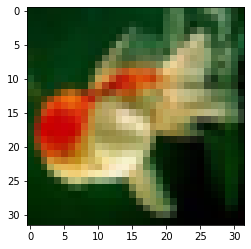

In [19]:
#@title Test qualitative results {run : 'auto'}
datapoint_number = 598 #@param{type : "integer"}
image, gt = cifar100_test[datapoint_number]
image_pixels = torchvision.transforms.functional.to_pil_image(image)
plt.imshow(image_pixels)
pr = loaded_student.mixer(image.unsqueeze(0).float())
#print(pr)
dataset.dataset.classes[gt],  dataset.dataset.classes[pr.argmax().item()]